In [19]:
import os
import time
import h5py
import glob
import time
import numpy as np
import xarray as xr

import pandas as pd
import geopandas as gpd

from shapely.geometry import Point

from scipy.optimize import differential_evolution

import cartopy.feature as cf
import cartopy.crs as ccrs

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from pathos.multiprocessing import ProcessingPool as Pool

from playsound import playsound

from joblib import Parallel, delayed

import sys
sys.path.insert(0, os.path.abspath("../function"))
from ART_downscale import wei_fit_update, fit_yearly_weibull_update, compute_beta, str_exp_fun, epl_fun, myfun_sse, down_wei
from ART_preprocessing import haversine, create_box, space_time_scales_agregations, wet_matrix_extrapolation, autocorrelation_neighborhood, area_lat_lon, spatial_correlation
from ART_plot import plot_neighborhood, plot_scales_aggregation, plot_wet_fraction_matrix, plot_autocorrelation, plot_scatter

import warnings
warnings.filterwarnings('ignore')

## Downscaling to Veneto region

In [20]:
product, time_reso, file = 'MSWEP', '3h', 'MSWEP_Italy_3h_1980_01_01_2023_12_31.nc'
# product, time_reso, file = 'CMORPH', '3h', 'CMORPH_Italy_3hr_1998_01_01_2023_12_31.nc'
# product, time_reso, file = 'IMERG', '3h', 'IMERG_Italy_3h_2001_01_01_2023_12_31.nc'

In [21]:
yy_s, yy_e = 2002, 2012
CONDITION = 'OVERLEAP'; fig_val = 'OVERLAP'

lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [22]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy','Veneto.geojson')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(veneto_dir)
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [23]:
from matplotlib import patches

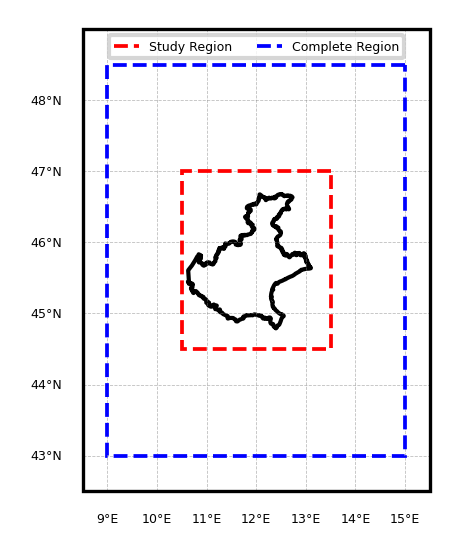

In [24]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(2,2),dpi=300)
gs = gridspec.GridSpec(1,1)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min-2, lon_max+2, lat_min-2, lat_max+2],crs=proj)
VENETO.plot(facecolor='None', ax=ax1)

ax1.add_patch(patches.Rectangle((lon_max,lat_max),lon_min-lon_max,lat_min-lat_max,linestyle='--',linewidth=0.9,edgecolor='r',facecolor='None',zorder=5))
ax1.add_patch(patches.Rectangle((lon_max+1.5,lat_max+1.5),(lon_min-1.5)-(lon_max+1.5),(lat_min-1.5)-(lat_max+1.5),linestyle='--',linewidth=0.9,edgecolor='b',facecolor='None',zorder=5))

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

ax1.plot([],[],linestyle='--',linewidth=0.9,color='r', label='Study Region')
ax1.plot([],[],linestyle='--',linewidth=0.9,color='b', label='Complete Region')

ax1.legend(fontsize=3,ncols=2,loc='upper center')

In [25]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite',product,time_reso)
data_dir = os.path.join(dir_base,file)

if os.path.exists(data_dir):
    DATA_in = xr.open_dataset(data_dir)
    DATA_in = DATA_in.sel(time=DATA_in.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))
else:
    raise SystemExit(f"File not found: {data_dir}")

if product == 'MSWEP':
    DATA_in = DATA_in.sel(lat=slice(lat_max+1.5, lat_min-1.5), lon=slice(lon_min-1.5, lon_max+1.5))
else:
    DATA_in = DATA_in.sel(lat=slice(lat_min-1.5, lat_max+1.5), lon=slice(lon_min-1.5, lon_max+1.5))

lats = DATA_in['lat'].data
lons = DATA_in['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon = np.size(lons)
nlat = np.size(lats)
ntime = len(DATA_in['time'])

dx = np.abs(lons[1] - lons[0])
dy = np.abs(lats[1] - lats[0])

year_vector = np.unique(pd.to_datetime(DATA_in['time']).year)

DATES = DATA_in['time'][:]

DATA_in

<xarray.Dataset> Size: 386MB
Dimensions:  (time: 32144, lat: 50, lon: 60)
Coordinates:
  * time     (time) datetime64[ns] 257kB 2002-01-01 ... 2012-12-31T21:00:00
  * lat      (lat) float32 200B 47.95 47.85 47.75 47.65 ... 43.25 43.15 43.05
  * lon      (lon) float32 240B 9.05 9.15 9.25 9.35 ... 14.65 14.75 14.85 14.95
Data variables:
    PRE      (time, lat, lon) float32 386MB ...
Attributes:
    description:  MSWEP 3 hours data in 1980 for Italy region

In [26]:
# Extract lat and lon points for VENETO
if product == 'MSWEP':
    ds_veneto = DATA_in.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
else:
    ds_veneto = DATA_in.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

lat_ref = ds_veneto.lat.values
lon_ref = ds_veneto.lon.values

ndices_lat = np.where(np.isin(lats, lat_ref))[0]
ndices_lon = np.where(np.isin(lons, lon_ref))[0]

lon2d_ref, lat2d_ref = np.meshgrid(lon_ref, lat_ref)

print(ds_veneto['PRE'].shape)

del ds_veneto

(32144, 25, 30)


In [27]:
# MSWEP
param = dict({
    'L1':10,
    'origin_x': 10,
    'radio':0.1,
    'npix':3,
    'thresh': 2,

    'maxmiss':40,
    'condition': 'OVERLEAP',

    'L0':0,
    'tmax': 48,
    'dt': 3,

    'origin_t': 24,
    'target_x': 0,
    'target_t': 24,

    'ninterp':2000,

    'acf': 'mar',
    'corr_method':'pearson',
    'BETA_cores': 3,
})

# # CMORPH
# param = dict({
#     'L1':25,
#     'origin_x': 25,
#     'radio':0.3,
#     'npix':3,
#     'thresh': 1,

#     'maxmiss':40,
#     'condition': 'OVERLEAP',

#     'L0':0,
#     'tmax': 48,
#     'dt': 3,

#     'origin_t': 24,
#     'target_x': 0,
#     'target_t': 24,

#     'ninterp':2000,

#     'acf': 'mar',
#     'corr_method':'pearson',
#     'BETA_cores': 4,
# })

# # IMERG
# param = dict({
#     'L1':10,
#     'origin_x': 10,
#     'radio':0.1,
#     'npix':3,
#     'thresh': 2,

#     'maxmiss':40,
#     'condition': 'OVERLEAP',

#     'L0':0,
#     'tmax': 48,
#     'dt': 3,

#     'origin_t': 24,
#     'target_x': 0,
#     'target_t': 24,

#     'ninterp':2000,

#     'acf': 'mar',
#     'corr_method':'pearson',
#     'BETA_cores': 3,
# })

In [28]:
def COMPUTE_BETA(DATA_in, lat_c, lon_c, PARAM):
    PRE_daily = DATA_in.resample(time ='D').sum(dim='time', skipna=False)

    i_ = np.where(lats==lat_c)[0][0]
    j_ = np.where(lons==lon_c)[0][0]

    IMERG_pixel_1dy = PRE_daily['PRE'][:,i_,j_].data

    IMERG_pixel_1dy_xr = xr.DataArray(
                    IMERG_pixel_1dy, 
                    coords={'time':PRE_daily['time'].values}, 
                    dims=('time'))

    IMERG_WEIBULL_YEAR = fit_yearly_weibull_update(
                    IMERG_pixel_1dy_xr, 
                    thresh=PARAM['thresh'], 
                    maxmiss=PARAM['maxmiss'])

    box_3h, _ = create_box(DATA_in, lat_c, lon_c, PARAM['npix'], reso=PARAM['radio'])

    smax = box_3h.shape[0] # max spatial scale
    tscales = np.array([1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 36, 48, 96])*PARAM['dt']
    tscales = tscales[tscales < PARAM['tmax'] + 0.001]
    xscales = np.arange(1, smax+1)
    xscales_km = xscales*PARAM['L1']
    ntscales = np.size(tscales)
    nsscales = np.size(xscales)

    WET_MATRIX = space_time_scales_agregations(
                box_3h, 
                PARAM['L1'], 
                PARAM['condition'], 
                tscales, 
                xscales, 
                PARAM['npix'], 
                PARAM['thresh'])

    xscales_km_2d, tscales_2d = np.meshgrid(xscales_km, tscales)
    ntscales = np.size(tscales)
    nxscales = np.size(xscales)

    tscales_INTER = np.linspace(np.min(tscales), np.max(tscales), PARAM['ninterp'])
    WET_MATRIX_INTER = np.zeros((PARAM['ninterp'], nxscales))

    for col in range(nxscales):
        WET_MATRIX_INTER[:, col] = np.interp(tscales_INTER, tscales, WET_MATRIX[:, col])

    WET_MATRIX_EXTRA, new_spatial_scale = wet_matrix_extrapolation(
                WET_MATRIX_INTER, 
                xscales_km, 
                tscales_INTER, 
                PARAM['L1'], 
                PARAM['npix'])

    origin_ref = [PARAM['origin_x'], PARAM['origin_t']]
    target_ref = [PARAM['target_x'], PARAM['target_t']]

    beta = compute_beta(WET_MATRIX_EXTRA, origin_ref, target_ref, new_spatial_scale, tscales_INTER)
    
    return beta

In [29]:
def compute_for_point(lat_idx, lon_idx):
    return COMPUTE_BETA(DATA_in, lats[lat_idx], lons[lon_idx], param)

In [30]:
start_time = time.time()

results = Parallel(n_jobs=param['BETA_cores'])(
    delayed(compute_for_point)(la, lo) for la in ndices_lat for lo in ndices_lon
    )

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_minutes = elapsed_time / 60  # Convertir a minutos

print(f"Elapsed time: {elapsed_minutes:.2f} minutes")

neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhood area: 3x3
neihgborhoo

In [31]:
BETA_VENETO = np.array(results).reshape(len(ndices_lat), len(ndices_lon))

In [32]:
PRE_daily = DATA_in.resample(time ='D').sum(dim='time', skipna=False)
PRE = PRE_daily['PRE'][:, ndices_lat, :][:, :, ndices_lon].values
del PRE_daily

In [33]:
#Export beta as netcdf
BETA_xr = xr.Dataset(data_vars={"BETA": (("lat","lon"), BETA_VENETO.data)},
                    coords={'lat': lats[ndices_lat], 'lon': lons[ndices_lon]},
                    attrs=dict(description=f"Beta of {product} for Veneto region limited as 10.5E to 13.5E and 44.5N to 47N"))

BETA_xr.BETA.attrs["units"] = "dimensionless"
BETA_xr.BETA.attrs["long_name"] = "Relation between Origin and Tarjet wet fraction"
BETA_xr.BETA.attrs["origname"] = "BETA"

BETA_xr.lat.attrs["units"] = "degrees_north"
BETA_xr.lat.attrs["long_name"] = "Latitude"

BETA_xr.lon.attrs["units"] = "degrees_east"
BETA_xr.lon.attrs["long_name"] = "Longitude"

In [34]:
BETA_xr

<xarray.Dataset> Size: 6kB
Dimensions:  (lat: 25, lon: 30)
Coordinates:
  * lat      (lat) float32 100B 46.95 46.85 46.75 46.65 ... 44.75 44.65 44.55
  * lon      (lon) float32 120B 10.55 10.65 10.75 10.85 ... 13.25 13.35 13.45
Data variables:
    BETA     (lat, lon) float64 6kB 1.062 1.032 1.055 ... 1.043 1.047 1.049
Attributes:
    description:  Beta of MSWEP for Veneto region limited as 10.5E to 13.5E a...

In [35]:
BETA_out = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite','BETA',f'VENETO_BETA_{product}_{yy_s}_{yy_e}.nc')
print(f'Export PRE data to {BETA_out}')
BETA_xr.to_netcdf(BETA_out)

Export PRE data to /media/arturo/Arturo/Data/Italy/Satellite/BETA/VENETO_BETA_MSWEP_2002_2012.nc


Export figure to: ../figures/VENETO_MSWEP_mean_beta.png


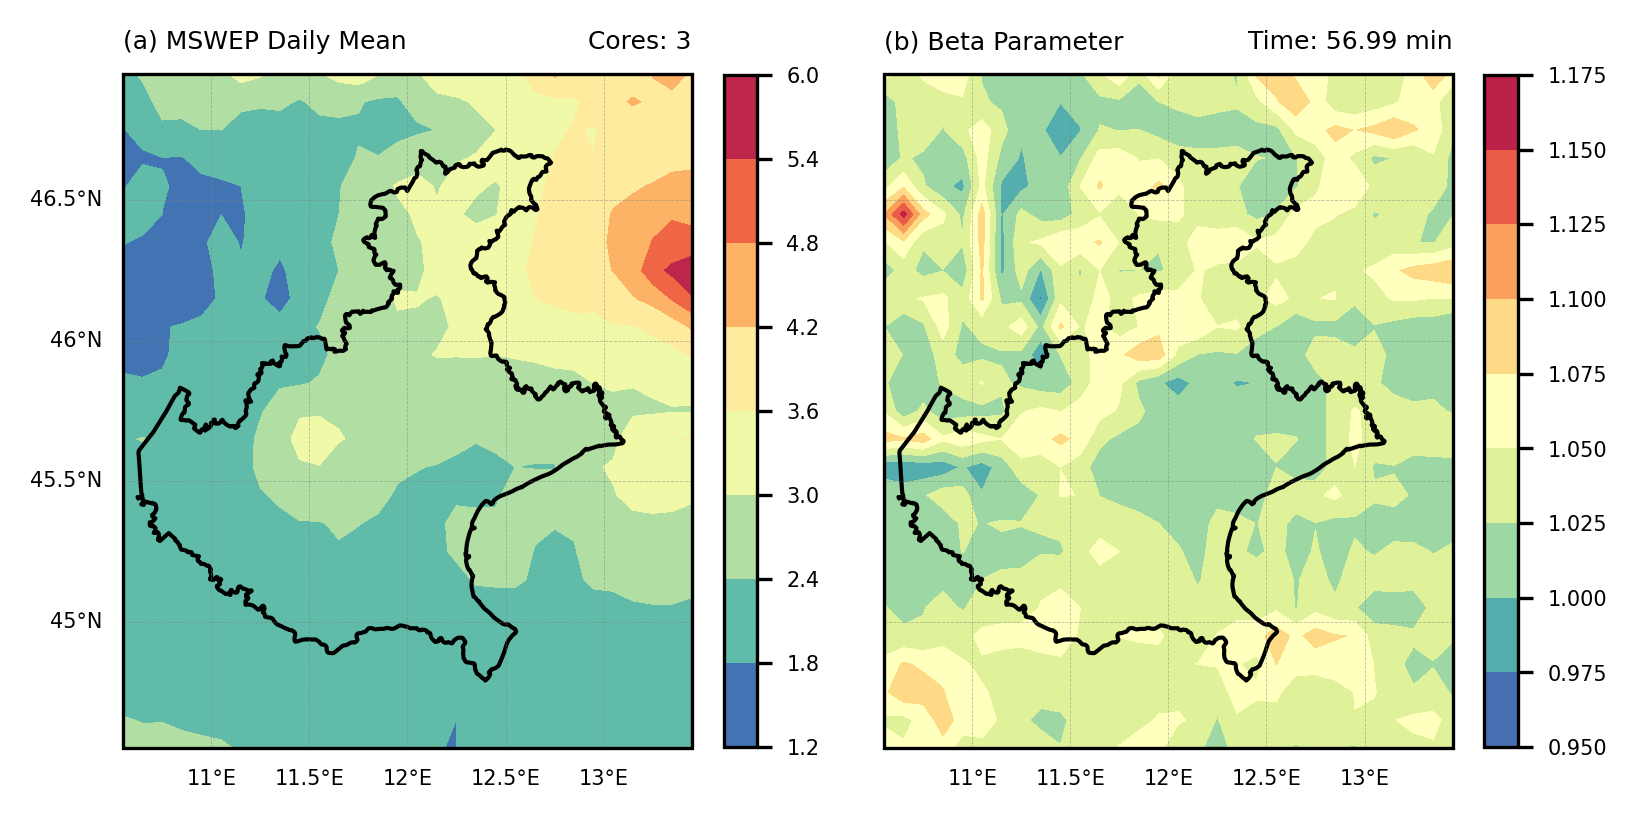

In [36]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)

a1 = ax1.contourf(lon2d_ref, lat2d_ref, np.nanmean(PRE,axis=0), cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=5)

ax1.set_title(f'(a) {product} Daily Mean', fontsize=6, loc='left')
ax1.set_title(f'Cores: {param['BETA_cores']}', fontsize=6, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)

a1 = ax1.contourf(lon2d_ref, lat2d_ref, BETA_VENETO, cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=5)

# Variance function between two scales (Gamma)
# Intermitency function between two scales (BETA)
ax1.set_title('(b) Beta Parameter', fontsize=6, loc='left')
ax1.set_title(f'Time: {elapsed_minutes:.2f} min', fontsize=6, loc='right')

salida = os.path.join('..','figures',f'VENETO_{product}_mean_beta.png')
print(f'Export figure to: {salida}')
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)